TODO: 
* Aggregate ds by one-second steps using pd.groupby(). See experiment using pd.merge_asof. Only problem is that it seems insensitive to the tolerance, so I can't trust that it's not joining depths from 10 minutes ago if the gps cut out...
* use time-varying offset instead of mean
* 2-D kernel filter for smoothing/spike removal?
* trace shoreline
* kriging in QGIS

NOTES:
* On 8/20 at BTL, mean offset was ~6 cm + 11.75 DS height (so add 17.75 cm to depths)

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
# import pytz

## On laptop
# shp_in='/mnt/c/Users/lsmith.DESKTOP-JJ8STSU/Google Drive/ABoVE top level folder/ABoVE2021/Etrex/shp/Track_2021-08-20 164201BTL DS track_points.shp'
# shp_out='/mnt/c/Users/lsmith.DESKTOP-JJ8STSU/Google Drive/ABoVE top level folder/ABoVE2021/Etrex/shp/joined-depths/Track_2021-08-20_164201BTL_DS_track_points_ds.shp'
# txt_in = '/mnt/c/Users/lsmith.DESKTOP-JJ8STSU/Google Drive/ABoVE top level folder/ABoVE2021/Depth-sounder/Teraterm/sonar_20210820_btl.log'

## On desktop
shp_in='/mnt/d/GoogleDrive/ABoVE top level folder/ABoVE2021/GPX_tracks/Etrex/shp/Track_2021-08-20 164201BTL DS track_points.shp'
shp_out='/mnt/f/ABoVE2021/Bathymetry-processed/joined-depths/Track_2021-08-20_164201BTL_DS_track_points_ds.shp'
txt_in = '/mnt/d/GoogleDrive/ABoVE top level folder/ABoVE2021/Depth-sounder/Teraterm/sonar_20210820_btl.log'

In [2]:
OS=0.1775 # depth sounder offset (just mean for now)

In [3]:
gdf = gpd.read_file(shp_in)
gdf.head()

,track_fid,track_seg_,track_se_1,ele,time,magvar,geoidheigh,name,cmt,desc,...,sym,type,fix,sat,hdop,vdop,pdop,ageofdgpsd,dgpsid,geometry
0,0,0,0,188.08,2021/08/20 22:08:18.000,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.2659052688 7199804.578296414 1...
1,0,0,1,187.59,2021/08/20 22:08:19.000,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.352510971 7199804.53046238 187...
2,0,0,2,187.59,2021/08/20 22:08:21.000,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0578322478 7199804.431515218 1...
3,0,0,3,187.59,2021/08/20 22:08:23.000,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.5636753015 7199804.303517605 1...
4,0,0,4,188.08,2021/08/20 22:08:24.000,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.69630626 7199804.441924766 188...


In [4]:
gdf['time'] = pd.to_datetime(gdf.time, utc=True)
gdf.head()
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9241 entries, 0 to 9240
Data columns (total 27 columns):
track_fid     9241 non-null int64
track_seg_    9241 non-null int64
track_se_1    9241 non-null int64
ele           9241 non-null float64
time          9241 non-null datetime64[ns, UTC]
magvar        0 non-null object
geoidheigh    0 non-null object
name          0 non-null object
cmt           0 non-null object
desc          0 non-null object
src           0 non-null object
link1_href    0 non-null object
link1_text    0 non-null object
link1_type    0 non-null object
link2_href    0 non-null object
link2_text    0 non-null object
link2_type    0 non-null object
sym           0 non-null object
type          0 non-null object
fix           0 non-null object
sat           0 non-null object
hdop          0 non-null object
vdop          0 non-null object
pdop          0 non-null object
ageofdgpsd    0 non-null object
dgpsid        0 non-null object
geometry      9241 non-null

In [5]:
gdf.set_index('time', inplace=True)
gdf.index
gdf.index = gdf.index.tz_convert('Etc/GMT+8') # AK daylight time
gdf.head()

,track_fid,track_seg_,track_se_1,ele,magvar,geoidheigh,name,cmt,desc,src,...,sym,type,fix,sat,hdop,vdop,pdop,ageofdgpsd,dgpsid,geometry
time,,,,,,,,,,,,,,,,,,,,,
2021-08-20 14:08:18-08:00,0,0,0,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.2659052688 7199804.578296414 1...
2021-08-20 14:08:19-08:00,0,0,1,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.352510971 7199804.53046238 187...
2021-08-20 14:08:21-08:00,0,0,2,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0578322478 7199804.431515218 1...
2021-08-20 14:08:23-08:00,0,0,3,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.5636753015 7199804.303517605 1...
2021-08-20 14:08:24-08:00,0,0,4,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.69630626 7199804.441924766 188...


In [6]:
## Round index to nearest S
gdf.index = gdf.index.round('S')

In [7]:
## View min/max dates to check timezone
print(gdf.index.min())
print(gdf.index.max())

2021-08-20 14:08:18-08:00
2021-08-20 16:42:26-08:00


In [8]:
depths = pd.read_csv(txt_in, sep=' ', parse_dates=None, header = None, names = ['date', 'time','d_hi_freq', 'd_low_freq'])
print(len(depths))
depths.head()

15355


,date,time,d_hi_freq,d_low_freq
0,[2021-08-20,14:34:23.369],0.0,0.0
1,[2021-08-20,14:34:23.389],0.0,0.0
2,[2021-08-20,14:34:23.389],0.0,0.0
3,[2021-08-20,14:34:23.389],0.0,0.0
4,[2021-08-20,14:34:23.389],0.0,0.0


In [9]:
depths['datetime']=depths.date + ' ' + depths.time
depths['datetime']=depths.datetime.str.replace("[", "").str.replace("]", "")
depths.head()

,date,time,d_hi_freq,d_low_freq,datetime
0,[2021-08-20,14:34:23.369],0.0,0.0,2021-08-20 14:34:23.369
1,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389
2,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389
3,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389
4,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389


In [10]:
depths['datetime'] = pd.to_datetime(depths['datetime'], format='%Y-%m-%d %H:%M:%S', utc=False)
depths.head()

,date,time,d_hi_freq,d_low_freq,datetime
0,[2021-08-20,14:34:23.369],0.0,0.0,2021-08-20 14:34:23.369
1,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389
2,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389
3,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389
4,[2021-08-20,14:34:23.389],0.0,0.0,2021-08-20 14:34:23.389


In [11]:
depths.drop(columns=['date', 'time'], inplace=True)
depths.set_index('datetime', inplace=True)
depths.head()

,d_hi_freq,d_low_freq
datetime,,
2021-08-20 14:34:23.369,0.0,0.0
2021-08-20 14:34:23.389,0.0,0.0
2021-08-20 14:34:23.389,0.0,0.0
2021-08-20 14:34:23.389,0.0,0.0
2021-08-20 14:34:23.389,0.0,0.0


In [12]:
## make timezone-aware
depths.index = depths.index.tz_localize('Etc/GMT+8')
depths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15355 entries, 2021-08-20 14:34:23.369000-08:00 to 2021-08-20 16:41:14.130000-08:00
Data columns (total 2 columns):
d_hi_freq     15355 non-null float64
d_low_freq    15355 non-null float64
dtypes: float64(2)
memory usage: 359.9 KB


In [13]:
## Round index to nearest S
depths.index = depths.index.round('S')

In [14]:
## View min/max dates to check timezone
print(depths.index.min())
print(depths.index.max())

2021-08-20 14:34:23-08:00
2021-08-20 16:41:14-08:00


/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_conv

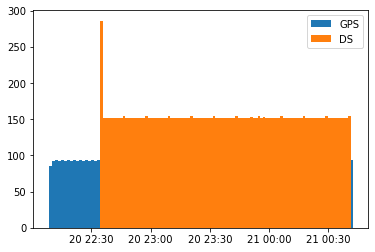

In [15]:
## View dates
plt.hist(gdf.index, bins=100, label='GPS') #, depths.index)
plt.hist(depths.index, bins=100, label='DS')
plt.legend()

In [16]:
## View to compare
depths[:50]
gps_start=np.where(gdf.index=='2021-08-20 14:34:23-08:00') # find index where GPS, which logged first, matches first DS meas
print(gps_start[0][0])
display(gdf.iloc[gps_start[0][0]:(gps_start[0][0]+10), :])
display(depths.iloc[0:10,:])

1557


,track_fid,track_seg_,track_se_1,ele,magvar,geoidheigh,name,cmt,desc,src,...,sym,type,fix,sat,hdop,vdop,pdop,ageofdgpsd,dgpsid,geometry
time,,,,,,,,,,,,,,,,,,,,,
2021-08-20 14:34:23-08:00,0,0,1557,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...
2021-08-20 14:34:24-08:00,0,0,1558,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.9345118758 7199806.236183375 1...
2021-08-20 14:34:25-08:00,0,0,1559,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.8582276348 7199806.162427704 1...
2021-08-20 14:34:26-08:00,0,0,1560,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.9340278319 7199806.19881771 18...
2021-08-20 14:34:27-08:00,0,0,1561,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0047804377 7199806.151189026 1...
2021-08-20 14:34:28-08:00,0,0,1562,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.9996071393 7199806.057831769 1...
2021-08-20 14:34:29-08:00,0,0,1563,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.8220349911 7199805.817231202 1...
2021-08-20 14:34:30-08:00,0,0,1564,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.6985404734 7199805.772118849 1...
2021-08-20 14:34:31-08:00,0,0,1565,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461243.696241504 7199805.594651427 18...


,d_hi_freq,d_low_freq
datetime,,
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0
2021-08-20 14:34:23-08:00,0.0,0.0


In [17]:
## Verify calculated startpoints are the same!

display(gdf.index[gps_start[0][0]])
display(depths.index[0])
gdf.index[gps_start[0][0]] == depths.index[0]

Timestamp('2021-08-20 14:34:23-0800', tz='Etc/GMT+8')

Timestamp('2021-08-20 14:34:23-0800', tz='Etc/GMT+8')

True

In [18]:
## join (note pd.mergeas() function takes nearest match within a tolerance!)
gdf_out = gdf.join(depths, how='inner')
display(gdf_out.head())
print(gdf_out.shape)

,track_fid,track_seg_,track_se_1,ele,magvar,geoidheigh,name,cmt,desc,src,...,fix,sat,hdop,vdop,pdop,ageofdgpsd,dgpsid,geometry,d_hi_freq,d_low_freq
2021-08-20 14:34:23-08:00,0,0,1557,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...,0.0,0.0
2021-08-20 14:34:23-08:00,0,0,1557,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...,0.0,0.0
2021-08-20 14:34:23-08:00,0,0,1557,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...,0.0,0.0
2021-08-20 14:34:23-08:00,0,0,1557,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...,0.0,0.0
2021-08-20 14:34:23-08:00,0,0,1557,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...,0.0,0.0


(15355, 28)


In [19]:
gdf_out2 = pd.merge_asof(gdf, depths, left_index=True, right_index=True)
display(gdf_out2.head())
print(gdf_out2.shape)

,track_fid,track_seg_,track_se_1,ele,magvar,geoidheigh,name,cmt,desc,src,...,fix,sat,hdop,vdop,pdop,ageofdgpsd,dgpsid,geometry,d_hi_freq,d_low_freq
time,,,,,,,,,,,,,,,,,,,,,
2021-08-20 14:08:18-08:00,0,0,0,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.2659052688 7199804.578296414 1...,NaN,NaN
2021-08-20 14:08:19-08:00,0,0,1,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.352510971 7199804.53046238 187...,NaN,NaN
2021-08-20 14:08:21-08:00,0,0,2,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.0578322478 7199804.431515218 1...,NaN,NaN
2021-08-20 14:08:23-08:00,0,0,3,187.59,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.5636753015 7199804.303517605 1...,NaN,NaN
2021-08-20 14:08:24-08:00,0,0,4,188.08,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT Z (461244.69630626 7199804.441924766 188...,NaN,NaN


(9241, 28)


In [20]:
gdf_out3 = pd.merge_asof(depths, gdf, left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta("50s"))
display(gdf_out3.head())
print(f'Shape: {gdf_out3.shape}')
print(f'Number of non-zero entries: {np.sum(gdf_out3.d_hi_freq>0)}')

,d_hi_freq,d_low_freq,track_fid,track_seg_,track_se_1,ele,magvar,geoidheigh,name,cmt,...,sym,type,fix,sat,hdop,vdop,pdop,ageofdgpsd,dgpsid,geometry
datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-20 14:34:23-08:00,0.0,0.0,0,0,1557,188.08,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...
2021-08-20 14:34:23-08:00,0.0,0.0,0,0,1557,188.08,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...
2021-08-20 14:34:23-08:00,0.0,0.0,0,0,1557,188.08,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...
2021-08-20 14:34:23-08:00,0.0,0.0,0,0,1557,188.08,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...
2021-08-20 14:34:23-08:00,0.0,0.0,0,0,1557,188.08,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT Z (461244.0939271291 7199806.299510809 1...


Shape: (15355, 28)
Number of non-zero entries: 14144


In [21]:
gdf_out3.groupby('datetime').mean().shape

(7612, 6)

In [22]:
## Dropt zero values - aet as nan
zero_idx = gdf_out.query('(d_hi_freq == 0) & (d_low_freq == 0)', inplace=False).index
gdf_out.loc[zero_idx, ['d_hi_freq', 'd_low_freq']]  = np.nan

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/pandas/core/generic.py:457: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/pandas/core/generic.py:465: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


In [23]:
## Add offset
gdf_out.d_low_freq += OS
gdf_out.d_hi_freq += OS

In [24]:
## Drop unncecc vars
gdf_out = gdf_out[['ele', 'd_hi_freq', 'd_low_freq', 'geometry']]

In [25]:
## Stats on two DS freqs

gdf_out['d_hilo_mean'] = (gdf_out.d_low_freq + gdf_out.d_hi_freq)/2
gdf_out['d_diff'] = gdf_out.d_low_freq - gdf_out.d_hi_freq
gdf_out['d_pdiff'] = 200* (gdf_out.d_low_freq - gdf_out.d_hi_freq) / (gdf_out.d_low_freq + gdf_out.d_hi_freq)

In [26]:
## Prepare to save as shapefile

gdf_out['datetime'] = gdf_out.index.astype('str') # remove datetime info to comply w ESRI shapefile
gdf_out.reset_index(inplace=True)
gdf_out.drop(columns='index', inplace=True)
gdf_out.head()

,ele,d_hi_freq,d_low_freq,geometry,d_hilo_mean,d_diff,d_pdiff,datetime
0,188.08,NaN,NaN,POINT Z (461244.0939271291 7199806.299510809 1...,NaN,NaN,NaN,2021-08-20 14:34:23-08:00
1,188.08,NaN,NaN,POINT Z (461244.0939271291 7199806.299510809 1...,NaN,NaN,NaN,2021-08-20 14:34:23-08:00
2,188.08,NaN,NaN,POINT Z (461244.0939271291 7199806.299510809 1...,NaN,NaN,NaN,2021-08-20 14:34:23-08:00
3,188.08,NaN,NaN,POINT Z (461244.0939271291 7199806.299510809 1...,NaN,NaN,NaN,2021-08-20 14:34:23-08:00
4,188.08,NaN,NaN,POINT Z (461244.0939271291 7199806.299510809 1...,NaN,NaN,NaN,2021-08-20 14:34:23-08:00


In [27]:
## Save as shapefile
gdf_out.to_file(shp_out)